In [2]:
import os
import glob
import time
import numpy as np 
import cv2
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
from PIL import Image

In [3]:
def get_closest(y, y_space):
    if y < y_space[0] or y > y_space[-1]:
        return None
    _min = None
    min_index = None
    for index, y_ in enumerate(y_space):
        if index == 0:
            _min = np.abs(y_ - y)
            min_index = index
        else:
            tmp = np.abs(y_ - y)
            if _min > tmp:
                _min = tmp
                min_index = index
    
    return min_index

In [40]:
# binary search
def get_closestBS(y, y_space):
    if y < y_space[0] or y > y_space[-1]: # if y out of bounds of image return None
        return None
    
    low = 0
    high = len(y_space) - 1
    middle = int((low + high) / 2)
    while (low <= high):
        middle = int((low + high) / 2)
        _min = abs(y_space[middle] - y)
        
        if middle - 1 >= 0 and middle + 1 <= len(y_space) - 1:
            if abs(y_space[middle - 1] - y) < _min: # left case
                high = middle - 1
            
            elif abs(y_space[middle + 1] - y) < _min: # right case
                low = middle + 1
        
            else:
                return middle
            
        elif middle - 1 >= 0:
            if abs(y_space[middle - 1] - y) < _min: # left case
                high = middle - 1
            
            else:
                return middle
            
        elif middle + 1 <= len(y_space) - 1:
            if abs(y_space[middle + 1] - y) < _min: # right case
                low = middle + 1
        
            else:
                return middle
            
    return middle

In [23]:
def make_img(min_x, max_x, min_y, max_y, x_pixels, function):
    dx = max_x - min_x
    dy = max_y - min_y
    
    ratio = float(dx)/dy
    
    # init x space and y space
    x_space = np.linspace(min_x, max_x, x_pixels)
    y_space = np.linspace(min_y, max_y, int(x_pixels / ratio))
    
    # init img
    img = np.zeros((len(y_space), len(x_space)), dtype=np.float32)
    
    for index, x in enumerate(x_space):
        y = function(x)
        closest = get_closestBS(y, y_space)
        if closest != None:
            y_index = len(y_space) - (1 + closest)
            img[y_index][index] = 255
    
    return img

In [22]:
im1 = make_img(-5, 5, -1, 1, 1000, lambda x: np.sin(x))

In [41]:
im2 = make_img(-5, 5, -1, 1, 1000, lambda x: np.sin(x))

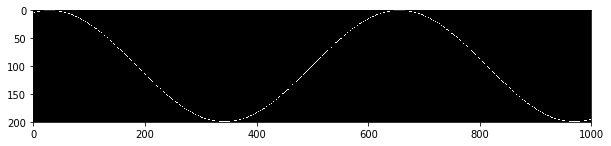

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(im1, cmap="gray")

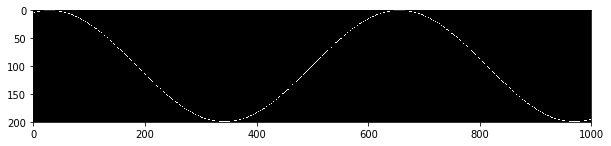

In [42]:
plt.figure(figsize=(10, 10))
plt.imshow(im2, cmap="gray")

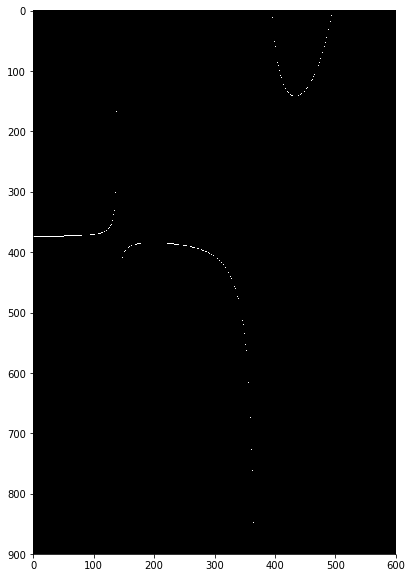

In [6]:
img = make_img(-5, 3, -7, 5, 600, lambda x: np.exp(x)/np.sin(x))
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap="gray")

## Making animations of graphs
___

In [6]:
import moviepy.editor as mvpy

In [14]:
def FunctionList(min_x, max_x, min_y, max_y, x_pixels, function, mod=1, width=1):
    dx = max_x - min_x
    dy = max_y - min_y
    
    ratio = float(dx)/dy
    
    # init x space and y space
    x_space = np.linspace(min_x, max_x, x_pixels)
    y_space = np.linspace(min_y, max_y, int(x_pixels / ratio))
    
    # init img
    img = np.zeros((len(y_space), len(x_space)), dtype=np.int32)
    
    order = [] # list to keep track of order of images in the video we will create
    x_prev = None
    y_prev = None
    x_space_len = len(x_space)-1
    for index, x in enumerate(x_space):
        y = function(x) 
    
        if (index != 0) and (index!=x_space_len):
            closest = get_closestBS(y, y_space)
            closest_prev = get_closestBS(y_prev, y_space)
            if closest!=None and closest_prev!=None:
                y_index = len(y_space) - (1 + closest)
                y_index_prev = len(y_space) - (1 + closest_prev)
                cv2.line(img, (index-1, y_index_prev), (index, y_index), (255, 255, 255))
        
        if (index % mod) == 0: # take img every mod pixels
            cv2.imwrite("./data/img-{}.jpg".format(index), np.dstack([img, img, img])) # write image to folder
            order.append("./data/img-{}.jpg".format(index)) # add image name to order list
        
        x_prev = x
        y_prev = y
    
    return order

def FunctionListDotted(min_x, max_x, min_y, max_y, x_pixels, function, mod=1, width=1):
    dx = max_x - min_x
    dy = max_y - min_y
    
    ratio = float(dx)/dy
    
    # init x space and y space
    x_space = np.linspace(min_x, max_x, x_pixels)
    y_space = np.linspace(min_y, max_y, int(x_pixels / ratio))
    
    # init img
    img = np.zeros((len(y_space), len(x_space)), dtype=np.int32)
    
    order = [] # list to keep track of order of images in the video we will create
    for index, x in enumerate(x_space):
        if (index % mod) == 0: # take img every mod pixels
            y = function(x) 
            y_index = len(y_space) - (1 + get_closest(y, y_space))
            bottom = y_index - width
            top = y_index + width
            if bottom < 0:
                bottom = 0
            if top > img.shape[0]:
                top = img.shape[0]
            img[bottom:top, index] = 255
            cv2.imwrite("./data/img-{}.jpg".format(index), np.dstack([img, img, img])) # write image to folder
            order.append("./data/img-{}.jpg".format(index)) # add image name to order list
    
    return order

def makeGraphAnimation(min_x, max_x, min_y, max_y, x_pixels, function, fps, fname, mod, width):
    d = []
    order = FunctionList(min_x, max_x, min_y, max_y, x_pixels, function, mod, width)
        
    clip = mvpy.ImageSequenceClip(order, fps=fps) # make clip object
    clip.write_videofile(fname, fps=fps) # write it to disk
    
def emptyDir(pathToDir, fileType="*"):
    for path in glob.glob("{}/{}".format(pathToDir, fileType)):
        os.unlink(path)

In [44]:
makeGraphAnimation(-2, 2, -1.1, 1.1, 3000, lambda x: np.sin(np.pi*x)*np.cos(3*x - 3)*np.cos(2*x)*np.sin(1.3*x - 0.5), 100, "wave3.mp4", 1, 0)

Moviepy - Building video wave3.mp4.
Moviepy - Writing video wave3.mp4



Moviepy - Done !
Moviepy - video ready wave3.mp4


## Making animations with respect to time
___

In [8]:
def getX(radius, angle):
    return np.cos(angle)*radius

def getY(radius, angle):
    return np.sin(angle)*radius

def timeImageMakerPolar(width, height, radius_function, angle_function, time, fps, mod):
    img = np.zeros((width, height), dtype=np.int32)
    order = []
    
    frames = int(fps*time)
    t_space = np.linspace(0, time, frames)
    center_x = int(width/2)
    center_y = int(height/2)
    prev_x, prev_y = None, None
    for index, t in enumerate(t_space):
        r_t = radius_function(t)
        a_t = angle_function(t)
        x_t = getX(r_t, a_t)
        y_t = getY(r_t, a_t)
        if prev_x != None and prev_y != None and (index % mod) == 0:
            cv2.line(img, (int(prev_x + center_x), int(prev_y + center_y)), (int(x_t + center_x), int(y_t + center_y)), (255, 255, 255))
            cv2.imwrite("./data/img-{}.jpg".format(index), np.dstack([img, img, img]))
            order.append("./data/img-{}.jpg".format(index))
        prev_x = x_t
        prev_y = y_t
    
    return order

def timeImageMakerCart(width, height, X_function, Y_function, time, fps, mod):
    img = np.zeros((width, height), dtype=np.int32)
    order = []
    
    frames = int(fps*time)
    t_space = np.linspace(0, time, frames)
    center_x = int(width/2)
    center_y = int(height/2)
    prev_x, prev_y = None, None
    for index, t in enumerate(t_space):
        x_t = X_function(t)
        y_t = Y_function(t)
        if prev_x != None and prev_y != None and (index % mod) == 0:
            cv2.line(img, (int(prev_x + center_x), int(prev_y + center_y)), (int(x_t + center_x), int(y_t + center_y)), (255, 255, 255))
            cv2.imwrite("./data/img-{}.jpg".format(index), np.dstack([img, img, img]))
            order.append("./data/img-{}.jpg".format(index))
        prev_x = x_t
        prev_y = y_t
    
    return order

def timeImageMakerFourier(width, height, radius_function, T, time, fps, mod):
    img = np.zeros((width, height), dtype=np.int32)
    order = []
    
    frames = int(fps*time)
    t_space = np.linspace(0, time, frames)
    center_x = int(width/2)
    center_y = int(height/2)
    prev_x, prev_y = None, None
    for index, t in enumerate(t_space):
        r_t = radius_function(t)
        a_t = 2*t*np.pi/T
        x_t = getX(r_t, a_t)
        y_t = getY(r_t, a_t)
        if prev_x != None and prev_y != None and (index % mod) == 0:
            cv2.line(img, (int(prev_x + center_x), int(prev_y + center_y)), (int(x_t + center_x), int(y_t + center_y)), (255, 255, 255))
            cv2.imwrite("./data/img-{}.jpg".format(index), np.dstack([img, img, img]))
            order.append("./data/img-{}.jpg".format(index))
        prev_x = x_t
        prev_y = y_t
    
    return order
    
def timeAnimation(width, height, radius_function, angle_function, time, fps, mod, fname):
    #order = timeImageMaker(width, height, radius_function, angle_function, time, fps, mod)
    order = timeImageMakerFourier(width, height, radius_function, 2.3, time, fps, mod)
    
    clip = mvpy.ImageSequenceClip(order, fps=fps)

    clip.write_videofile(fname, fps=fps)

In [27]:
timeAnimation(1000, 1000, lambda x: 350*np.sin(x)*np.cos(3*x -4), lambda x: x*0.6, 30, 150, 1, "fourier.mp4")

Moviepy - Building video fourier.mp4.
Moviepy - Writing video fourier.mp4



Moviepy - Done !
Moviepy - video ready fourier.mp4


## Making animations of functions as parameter changes
___

In [55]:
def FunctionChange(min_x, max_x, min_y, max_y, x_pixels, function, p_min, p_max, fps, time):
    order = []
    p_space = np.linspace(p_min, p_max, int(time*fps))
    for index, p in enumerate(p_space):
        make_img_param(min_x, max_x, min_y, max_y, x_pixels, function, p, index)
        order.append("./data/img-{}.jpg".format(index))
        
    return order

def Panimation(min_x, max_x, min_y, max_y, x_pixels, function, p_min, p_max, fps, fname, time):
    order = FunctionChange(min_x, max_x, min_y, max_y, x_pixels, function, p_min, p_max, fps, time)
    
    clip = mvpy.ImageSequenceClip(order, fps=fps)
    clip.write_videofile(fname, fps=fps)
    
    return clip

In [56]:
def make_img_param(min_x, max_x, min_y, max_y, x_pixels, function, parameter, i):
    dx = max_x - min_x
    dy = max_y - min_y
    
    ratio = float(dx)/dy
    
    # init x space and y space
    x_space = np.linspace(min_x, max_x, x_pixels)
    y_space = np.linspace(min_y, max_y, int(x_pixels / ratio))
    
    # init img
    img = np.zeros((len(y_space), len(x_space)), dtype=np.int32)
    prev_x, prev_y = None, None
    for index, x in enumerate(x_space):
        y = function(parameter, x)
        if (index != 0) and (index!=len(x_space)-1):
                closest = get_closestBS(y, y_space)
                closest_prev = get_closestBS(prev_y, y_space)
                if closest!=None and closest_prev!=None:
                    y_index = len(y_space) - (1 + closest)
                    y_index_prev = len(y_space) - (1 + closest_prev)
                    cv2.line(img, (index-1, y_index_prev), (index, y_index), (255, 255, 255))
        prev_x = x
        prev_y = y
        
    cv2.imwrite("./data/img-{}.jpg".format(i), np.dstack([img, img, img]))

In [74]:
clip = Panimation(-3, 3, -1, 9, 1000, lambda p, x: p*x**2, 0, 1, 150, "parameter.mp4", 1)

Moviepy - Building video parameter.mp4.
Moviepy - Writing video parameter.mp4



Moviepy - Done !
Moviepy - video ready parameter.mp4
